# Notebook - Capstone Project (Big Apple Burgers)

## Introduction

Burgers are comforting foods and come in very handy while you are travelling a city and want to have a quick bite. One of the busiest cities in the world -New York is bound to have decent proportion of burger food joints to cater to its masses. The aim of this project is to identify and direct tourist and foodies to popular burger places in NYC. 

After completing this project the questions that one can answer are: 
1. Which Burger Joints are present in New York City. 
2. Which Borough and Neighborhood have the highest concentration of Burger Joints. 
3. Identify the Neighborhoods with top average ratings for Burger Joints 
4. Which Burger Joints have the highest ratings (Based on "Likes", "Ratings" and "Tips") 


## Data Required

Data on the 5 boroughs as well as the neighborhoods that exist in each borough. The latitude and longitude coordinates of each neighborhood are required as well. This information will be obtained from https://cocl.us/new_york_dataset. 
Detailed information on Burger joints in New York City. This will be obtained from Foursquare. Foursquare will be able to provide us with detailed information of all the burger joints in New York such as location, ratings, likes, reviews, tips, etc. 
By merging both sources of information we will be able to obtain the information required to solve the business problem/questions. 

## Methodology section

We will start off by downloading, loading and exploring the neighborhood and borough data for New York city. We then Create a map of New York with neighbourhoods superimposed on top. This will help us better visualize the neighbourhoods present in New York City and its distribution. We also create a bar chart to identify the number of neighbourhoods per Borough in New York City. We then move on to identify the number of burger joints in each neighbourhood using the four square API. We can see that there are 97 burger joints in New York City. We then move on to identify the number of burger joints per borough in New York City. We then move on to find out the concentration of the burger joints in each Neighbourhood. Now we will get the ranking of each burger joint for further analysis. From that, we sought to identify the top-ranking burger joint in terms of 1. Likes 2. Tips 3. Ratings. We then move on to a more macro view which seeks to identify the boroughs with the highest rating. We then move on to take a look at the Neighbourhoods with the highest rating

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

## Obtaining New York City Data

In [21]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [22]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [25]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(new_york_data['Borough'].unique()),
        new_york_data.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Use geopy library to get the latitude and longitude values of New York City.

In [57]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Create a map of New York with neighborhoods superimposed on top.

In [29]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(new_york_data['Latitude'], new_york_data['Longitude'], new_york_data['Borough'], new_york_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Identifying the different type of neighborhoods in New York through the use of a Bar Graph

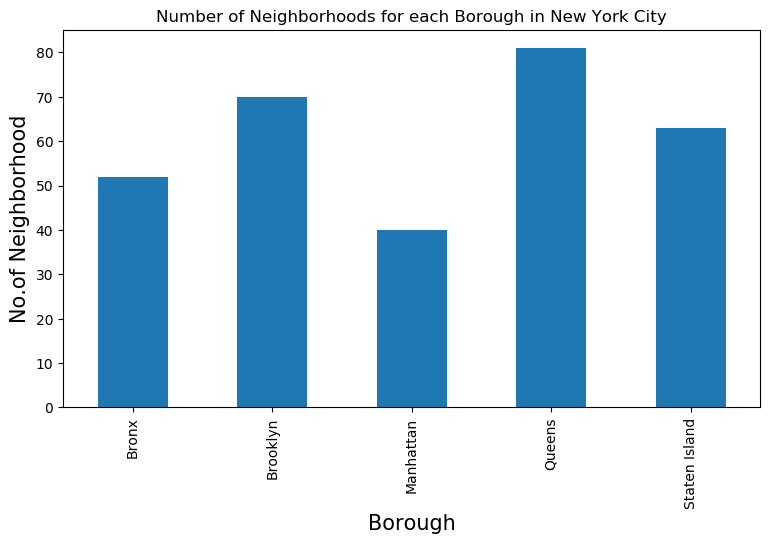

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhoods for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.show()

### Based on the graph above, it is evident that Queens has the highest number of neighborhoods

### Define Foursquare Credentials and Version

In [13]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = ''

# your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


### Setting the functions for Foursquare

In [42]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
        
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Identifying the number of burger joints in each Neighborhood

In [76]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
burger_joints_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,longitude)
    burger_joints=venues[venues['Category']=='Burger Joint']   
    print('(',count,'/',len(new_york_data),')','Burger Joints in '+Neighborhood+', '+Borough+':'+str(len(burger_joints)))
    for resturant_detail in burger_joints.values.tolist():
        id, name , category=resturant_detail
        burger_joints_ny = burger_joints_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Burger Joints in Wakefield, Bronx:1
( 2 / 306 ) Burger Joints in Co-op City, Bronx:0
( 3 / 306 ) Burger Joints in Eastchester, Bronx:0
( 4 / 306 ) Burger Joints in Fieldston, Bronx:1
( 5 / 306 ) Burger Joints in Riverdale, Bronx:0
( 6 / 306 ) Burger Joints in Kingsbridge, Bronx:0
( 7 / 306 ) Burger Joints in Marble Hill, Manhattan:0
( 8 / 306 ) Burger Joints in Woodlawn, Bronx:1
( 9 / 306 ) Burger Joints in Norwood, Bronx:0
( 10 / 306 ) Burger Joints in Williamsbridge, Bronx:0
( 11 / 306 ) Burger Joints in Baychester, Bronx:0
( 12 / 306 ) Burger Joints in Pelham Parkway, Bronx:0
( 13 / 306 ) Burger Joints in City Island, Bronx:1
( 14 / 306 ) Burger Joints in Bedford Park, Bronx:0
( 15 / 306 ) Burger Joints in University Heights, Bronx:0
( 16 / 306 ) Burger Joints in Morris Heights, Bronx:1
( 17 / 306 ) Burger Joints in Fordham, Bronx:0
( 18 / 306 ) Burger Joints in East Tremont, Bronx:1
( 19 / 306 ) Burger Joints in West Farms, Bronx:1
( 20 / 306 ) Burger Joints in High  Br

In [77]:
burger_joints_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4f73beb8e4b082acd0a22767,Gotham Burger Co.
1,Bronx,Fieldston,4f73beb8e4b082acd0a22767,Gotham Burger Co.
2,Bronx,Woodlawn,4f73beb8e4b082acd0a22767,Gotham Burger Co.
3,Bronx,City Island,53dd1196498e9abfcc432258,Mr. Burger
4,Bronx,Morris Heights,53dd1196498e9abfcc432258,Mr. Burger


In [78]:
burger_joints_ny.shape

(97, 4)

### We can see that there are a total of 97 burger joints across New York City. 

### Let us now find out the concentration of the burger joints in each Borough

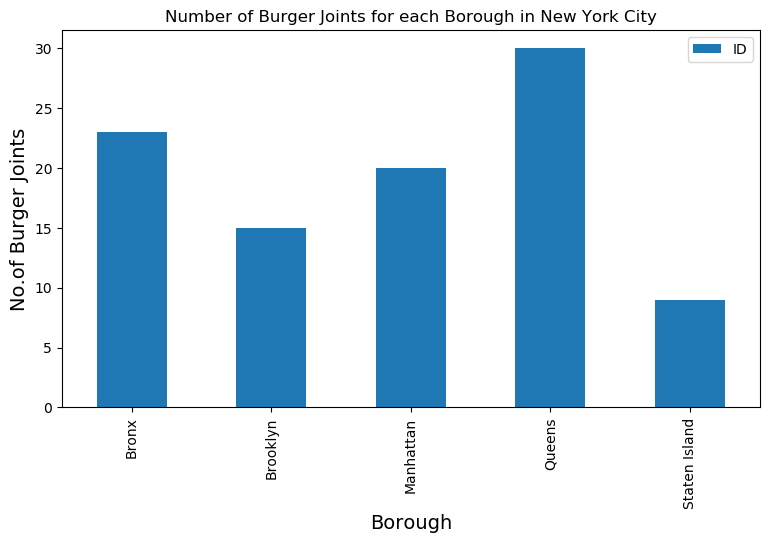

In [79]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Burger Joints for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 14)
#On y-axis
plt.ylabel('No.of Burger Joints', fontsize=14)
#giving a bar plot
burger_joints_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From this we can see Queens has the highest number of burger joints

### Let us now find out the concentration of the burger joints in each Neighborhood

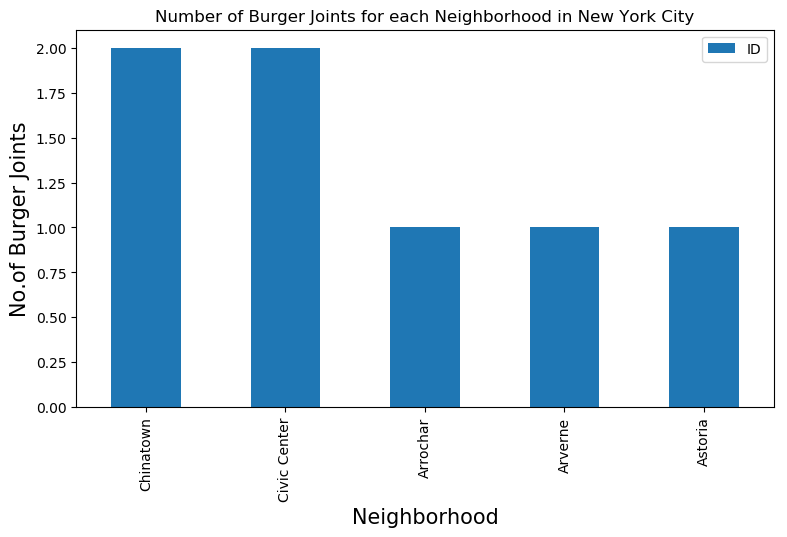

In [80]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Burger Joints for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Burger Joints', fontsize=15)
#giving a bar plot
burger_joints_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### We can see that Chinatown and Civic Center has the highest number of burger joints of 2. Important! - This classification is based on Foursquare's classification of Burger Joints. There could be restaurants that sells burger but classified differently.

### Now we will get the ranking of each burger joint for further analysis.

In [81]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
burger_joints_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in burger_joints_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    burger_joints_stats_ny = burger_joints_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID               Name  Likes  Rating  Tips
0  4f73beb8e4b082acd0a22767  Gotham Burger Co.      8     7.2     5
( 1 / 31 ) processed
                         ID               Name  Likes  Rating  Tips
0  4f73beb8e4b082acd0a22767  Gotham Burger Co.      8     7.2     5
( 2 / 31 ) processed
                         ID               Name  Likes  Rating  Tips
0  4f73beb8e4b082acd0a22767  Gotham Burger Co.      8     7.2     5
( 3 / 31 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 53dd1196498e9abfcc432258
( 4 / 31 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 53dd1196498e9abfcc432258
( 5 / 31 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 53dd1196498e9abfcc432258
( 6 / 31 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 53dd1196498e9abfcc4

In [82]:
burger_joints_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,4f73beb8e4b082acd0a22767,Gotham Burger Co.,8,7.2,5
1,Bronx,Fieldston,4f73beb8e4b082acd0a22767,Gotham Burger Co.,8,7.2,5
2,Bronx,Woodlawn,4f73beb8e4b082acd0a22767,Gotham Burger Co.,8,7.2,5
3,Bronx,City Island,0,0,0,0.0,0
4,Bronx,Morris Heights,0,0,0,0.0,0


In [83]:
burger_joints_stats_ny.shape

(97, 7)

In [84]:
burger_joints_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [90]:
burger_joints_stats_ny['Likes']=burger_joints_stats_ny['Likes'].astype('float64')
burger_joints_stats_ny['Tips']=burger_joints_stats_ny['Tips'].astype('float64')
burger_joints_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 7 columns):
Borough         97 non-null object
Neighborhood    97 non-null object
ID              97 non-null object
Name            97 non-null object
Likes           97 non-null float64
Rating          97 non-null float64
Tips            97 non-null float64
dtypes: float64(3), object(4)
memory usage: 5.4+ KB


### Identifying which burger joint ranks first in terms of 'Likes'

In [91]:
burger_joints_stats_ny.iloc[burger_joints_stats_ny['Likes'].idxmax()]

Borough                           Queens
Neighborhood                      Corona
ID              3fd66200f964a52096e91ee3
Name                       Corner Bistro
Likes                               1065
Rating                               8.3
Tips                                 392
Name: 49, dtype: object

### Corner Bistro located in Corona, Queens has the most number of likes at 1065

### Identifying which burger joint ranks first in terms of 'Tips'

In [92]:
burger_joints_stats_ny.iloc[burger_joints_stats_ny['Tips'].idxmax()]

Borough                           Queens
Neighborhood                      Corona
ID              3fd66200f964a52096e91ee3
Name                       Corner Bistro
Likes                               1065
Rating                               8.3
Tips                                 392
Name: 49, dtype: object

### Corner Bistro located in Corona, Queens has the most number of Tips at 392

### Identifying which burger joint ranks first in terms of 'Ratings'

In [93]:
burger_joints_stats_ny.iloc[burger_joints_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              5787b68e498efcabbebba4f8
Name                         Shake Shack
Likes                                505
Rating                               8.7
Tips                                  80
Name: 23, dtype: object

### Shake Shack located in Williamsburg, Brooklyn has the highest rating at 8.7

### Now let us take a look at the boroughs with the highest rating

In [99]:
ny_brh_stats=burger_joints_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_brh_stats.columns=['Borough','Average Rating']

ny_brh_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Borough,Average Rating
4,Staten Island,8.200000
1,Brooklyn,7.653333
2,Manhattan,6.945000
3,Queens,6.090000
0,Bronx,3.778261


### Staten Island is home to the best burger joints

### Now let us take a look at the Neighborhoods with the highest rating

In [96]:
ny_nbh_stats=burger_joints_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_nbh_stats.columns=['Neighborhood','Average Rating']
ny_nbh_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
75,Ridgewood,8.7
91,Williamsburg,8.7
34,Forest Hills Gardens,8.7
68,North Side,8.7
39,Hollis,8.7
6,Battery Park City,8.7
32,Financial District,8.7
29,East Williamsburg,8.7
10,Briarwood,8.7
46,Jamaica Hills,8.7


### Please refer to the table above to see the top 10 neighborhoods in terms of average burger joint ratings

# Conclusion

We will now be able answer all of the previously raised questions

1. There are 97 burger joints acrosss NYC
2. Borough that have the highest concentration of Burger Joints - Queens, neighbourhood that have the highest concentration of Burger Joints - Chinatown and Civic Center
3. Multiple neighborhoods are tied at 8.7 rating for the best burger joints
4. The best burger joint in terms of likes and tips is the Corner Bistro located in Corona, Queens while the best burger joint in terms of rating is Shake Shack located in Williamsburg, Brooklyn